# <center> Сегментация клиентов онлайн магазина подарков

## Описание проекта

Набор данных содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Проведение предобработки исходного набора данных о транзакциях;
2. Проведение разведывательного анализа данных и выявление основных закономерностей;
3. Формирование набора данных о характеристиках каждого из уникальных клиентов;
4. Построение нескольких моделей машинного обучения, решающих задачу кластеризации клиентов, определение количества кластеров и их интерпретация.

### Описание данных

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Информация о данных:
- В заказе может быть указано отрицательное количество товара (Quantity < 0). Как правило, это свидетельствует о возврате товара, но также может означать скидки.
- В системе учёта транзакций на каждый уникальный товар в заказе заводится отдельная транзакция.
- На возврат каждого уникального товара также заводится отдельная транзакция (уникальная запись в таблице).
- Номер заказа (InvoiceNo) может содержать не только числа, но и символы: например, символ 'C' перед номером заказа указывает на признак возврата. То есть в таблице должна находиться запись с такими же идентификаторами клиента и товара, но номером заказа без символа 'C' и с положительным количеством товара.
- Код товара (StockCode) также может содержать не только числа, но и символы: например, 'D' означает, что товар является скидочным и на такие товары нет аналогов с положительным числом товаров в заказе.
- Не все заказы с отрицательным количеством товара имеют в таблице свои аналоги (контрагентов). 

Импорт библиотек:

In [ ]:
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.tools import mpl_to_plotly

from sklearn.decomposition import TruncatedSVD, PCA
from country_converter import CountryConverter
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from ml.preprocessing import extract_datetime_features, OutlierCleaner
from ml.clusterization import find_best_n
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings 
warnings.filterwarnings('ignore')
pio.renderers.default = "png"

## 1. Загрузка и предобработка данных

In [2]:
df = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(df.shape))
df

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', utc=True)

In [4]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048+00:00,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00+00:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00+00:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00+00:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00+00:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00+00:00,38970.000000,NaN,NaN


- Количество транзакций - 541909
- Данные предоставлены в диапазоне с 2010-12-01 по 2011-12-09
- Количество заказов - 25900, клиентов - 4372, стран - 38
- Количество уникальных товаров - 4070
- Среднее количество товаров в заказе - 10, средняя цена за товар - 4.6 фунтов стерлингов

### 1.1. Обработка пропусков

In [5]:
nulls = df.isnull().sum()
nulls.sum()

136534

In [6]:
nulls[nulls > 0]

Description      1454
CustomerID     135080
dtype: int64

In [7]:
df['Description'] = df['Description'].fillna('')
df.dropna(subset=['CustomerID'], inplace=True)

### 1.2. Удаление дубликатов

In [8]:
duplicates = df.index[df.duplicated()]
df.drop(index=duplicates, inplace=True)
print(f'Удалено {len(duplicates)} дубликатов')

Удалено 5225 дубликатов


In [9]:
def get_quantity_canceled(data):
    """Создание признака, указывающего на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом.
    Для транзакций, для которых не было возвратов, признак будет равен 0. 
    Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым."""
    # Сортировка по покупателю, товару и дате
    sorted_data = data.sort_values(['CustomerID', 'StockCode', 'InvoiceDate'])

    # Инициализация результата
    result = pd.Series(0.0, index=data.index, dtype=float)

    # Группировка по клиенту и коду товара
    for (customer_id, stock_code), group in sorted_data.groupby(['CustomerID', 'StockCode']):
        # Словарь для хранения покупок
        purchases = []

        for idx, row in group.iterrows():
            if row['Quantity'] > 0:
                # Это покупка - добавление в список
                purchases.append({
                    'idx': idx,
                    'date': row['InvoiceDate'],
                    'quantity': row['Quantity'],
                    'used': 0  # Сколько уже было отменено
                })
            elif row['Quantity'] < 0:
                # Это возврат - поиск подходящей покупки
                return_qty = -row['Quantity']

                # Поиск самой поздней покупки с достаточным количеством
                suitable_purchase = None
                for purchase in reversed(purchases):
                    available_qty = purchase['quantity'] - purchase['used']
                    if purchase['date'] < row['InvoiceDate'] and available_qty >= return_qty:
                        suitable_purchase = purchase
                        break

                if suitable_purchase:
                    # Покупка-контрагент найдена
                    suitable_purchase['used'] += return_qty
                    result.loc[suitable_purchase['idx']] += return_qty
                else:
                    # Контрагент не найден
                    result.loc[idx] = np.nan

    return result


df['QuantityCanceled'] = get_quantity_canceled(df)

In [10]:
print(f'{df['QuantityCanceled'].isnull().sum()} транзакций не имеют контрагентов')
df = df[df['Quantity'] > 0] # Возвраты больше не нужны
df.dropna(inplace=True) # Удаление транзакций без контрагентов

1430 транзакций не имеют контрагентов


Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нужно удалить

In [11]:
# Удаление специальных видов транзакций
df = df[~df['StockCode'].str.contains(r'^[a-zA-Z]+')]

In [12]:
# Удаление товаров с ценой 0 (их меньше 1%)
df = df[~(df['UnitPrice'] == 0)]

In [13]:
# Общая цена заказа
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])

In [14]:
country_sr = df['Country']
country_sr = country_sr.replace({'EIRE': 'Ireland',
                                 'Channel Islands': 'GG',
                                 'RSA': 'South Africa'})
cc = CountryConverter()
# Признак со страной проживания в ISO3 формате
df['CountryISO3'] = cc.pandas_convert(series=country_sr)
# Признак с континентом проживания
df['Continent'] = cc.pandas_convert(series=df['CountryISO3'], to='UNregion')

Unspecified not found in regex
European Community not found in regex
not found not found in regex


In [15]:
# Добавление временных признаков
df = pd.concat([df, extract_datetime_features(df['InvoiceDate'], get_holidays=False)], axis=1)

## 2. Разведывательный анализ

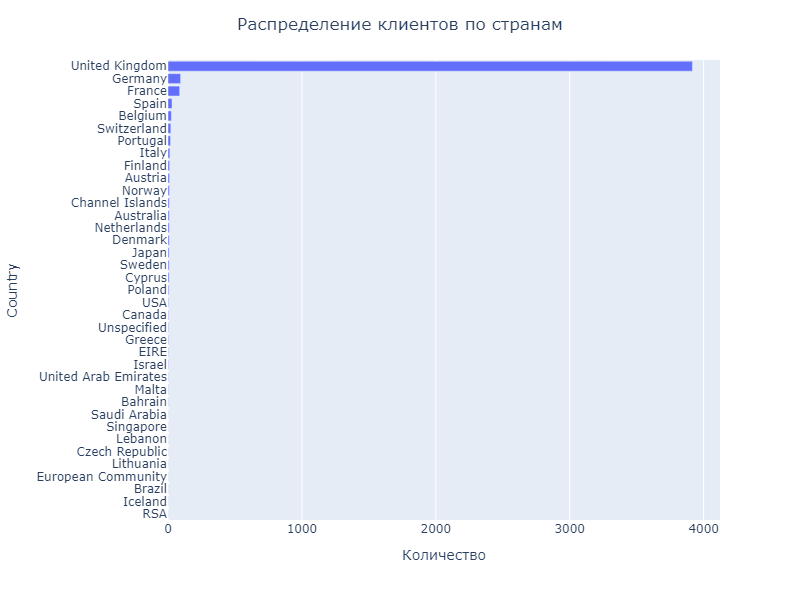

In [16]:
px.bar(df[['CustomerID', 'Country']].drop_duplicates()['Country'].value_counts().sort_values(ascending=True), labels={'value': 'Количество'},
       orientation='h', width=800, height=600).update_layout(showlegend=False, yaxis_tickmode='linear', title_text='Распределение клиентов по странам', title_x=0.5)

Практически все клиенты делают заказы из Великобритании

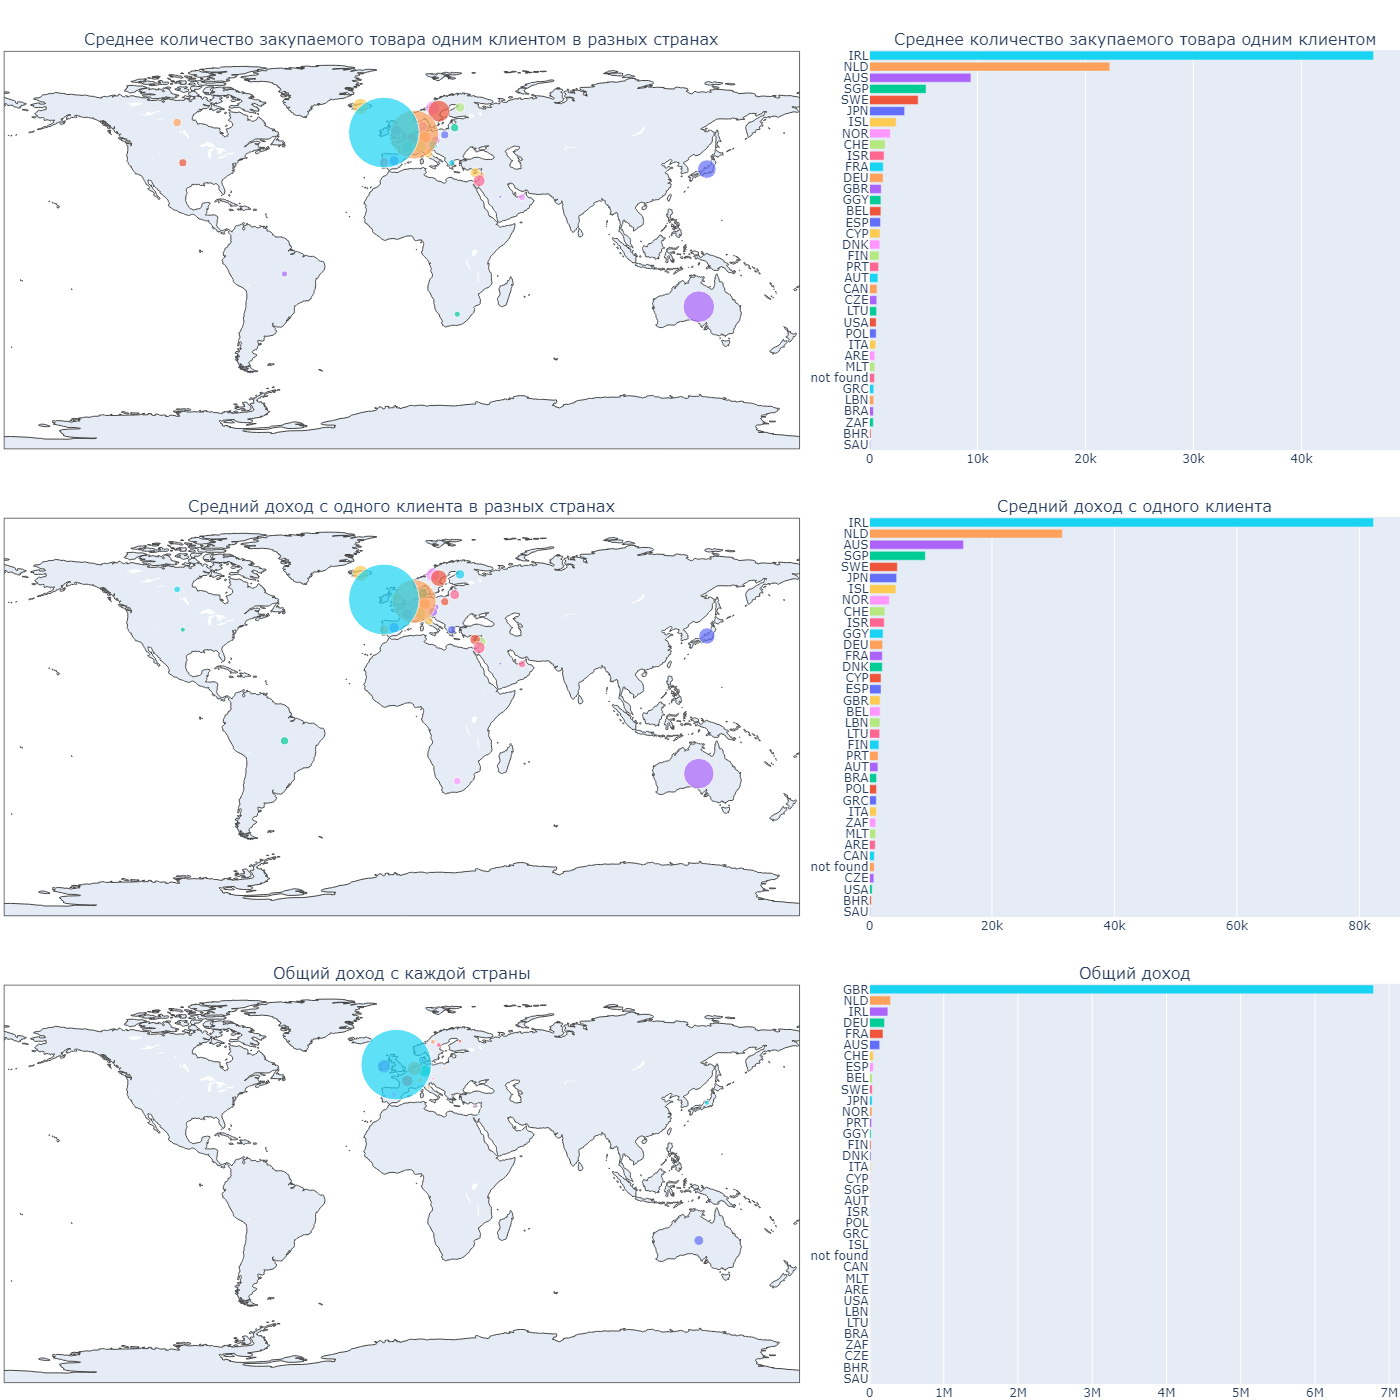

In [17]:
# Сколько в среднем товара закупает один клиент в каждой стране
country_mean_quant = df.groupby('CustomerID')['Quantity'].sum().reset_index() \
    .merge(df[['CountryISO3', 'CustomerID']].drop_duplicates(), how='left', on='CustomerID') \
    .groupby('CountryISO3')['Quantity'].mean().reset_index() \
    .sort_values(by='Quantity')

# Сколько в среднем прибыли приносит один клиент в каждой стране
country_mean_totalprice = df.groupby('CustomerID')['TotalPrice'].sum().reset_index() \
    .merge(df[['CountryISO3', 'CustomerID']].drop_duplicates(), how='left', on='CustomerID') \
    .groupby('CountryISO3')['TotalPrice'].mean().reset_index() \
    .sort_values(by='TotalPrice')

# Общий доход с каждой страны
countries_income = df.groupby('CountryISO3')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice')

fig = make_subplots(rows=3, cols=2, specs=[[{"type": "scattergeo"}, {"type": "bar"}],
                                           [{"type": "scattergeo"}, {"type": "bar"}],
                                           [{"type": "scattergeo"}, {"type": "bar"}]],
                    subplot_titles=['Среднее количество закупаемого товара одним клиентом в разных странах',
                                    'Среднее количество закупаемого товара одним клиентом',
                                    'Средний доход с одного клиента в разных странах',
                                    'Средний доход с одного клиента',
                                    'Общий доход с каждой страны',
                                    'Общий доход'],
                    vertical_spacing=0.05, horizontal_spacing=0.05, column_widths=[0.6, 0.4])
fig.add_traces(px.scatter_geo(country_mean_quant,
               locations='CountryISO3', size='Quantity', color='CountryISO3', size_max=50, locationmode='ISO-3').data, rows=1, cols=1)
fig.add_traces(px.bar(country_mean_quant, y='CountryISO3', x='Quantity', color='CountryISO3').data, rows=1, cols=2)
fig.add_traces(px.scatter_geo(country_mean_totalprice,
               locations='CountryISO3', size='TotalPrice', color='CountryISO3', size_max=50, locationmode='ISO-3').data, rows=2, cols=1)
fig.add_traces(px.bar(country_mean_totalprice, y='CountryISO3', x='TotalPrice', color='CountryISO3').data, rows=2, cols=2)
fig.add_traces(px.scatter_geo(countries_income,
               locations='CountryISO3', size='TotalPrice', color='CountryISO3', size_max=50, locationmode='ISO-3').data, rows=3, cols=1)
fig.add_traces(px.bar(countries_income, y='CountryISO3', x='TotalPrice', color='CountryISO3').data, rows=3, cols=2)
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0), width=1400, height=1400, showlegend=False,
                  yaxis1=dict(tickmode='linear'), yaxis2=dict(tickmode='linear'), yaxis3=dict(tickmode='linear'))

- Больше всех покупают товаров и приносят прибыль клиенты из Ирландии, Нидерландов и Австралии
- Наибольший общий доход приносят клиенты из Великобритании, Нидерландов и Ирландии

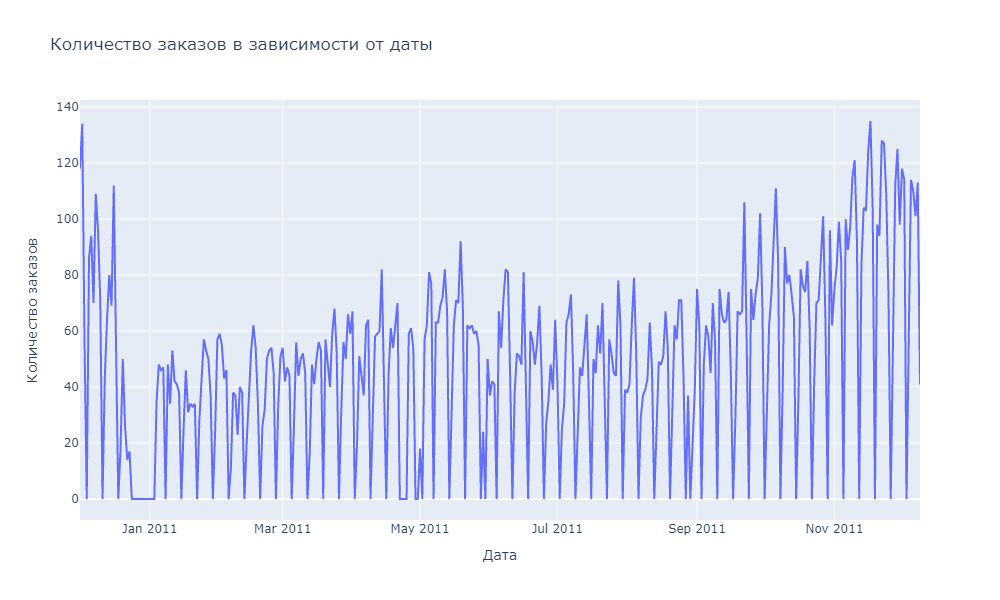

In [18]:
timeseries_count:pd.Series = df[['CustomerID', 'InvoiceDate']].drop_duplicates()['InvoiceDate'].value_counts().sort_index().resample('d').sum()
px.line(timeseries_count, title='Количество заказов в зависимости от даты',
        width=1000, height=600, labels={'value':'Количество заказов', 'InvoiceDate': 'Дата'}).update_layout(showlegend=False)

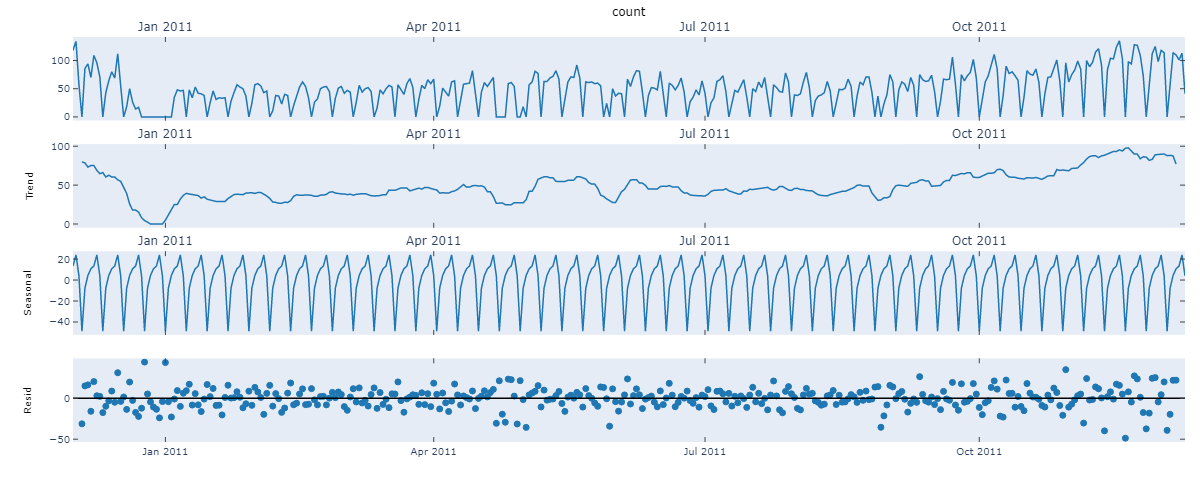

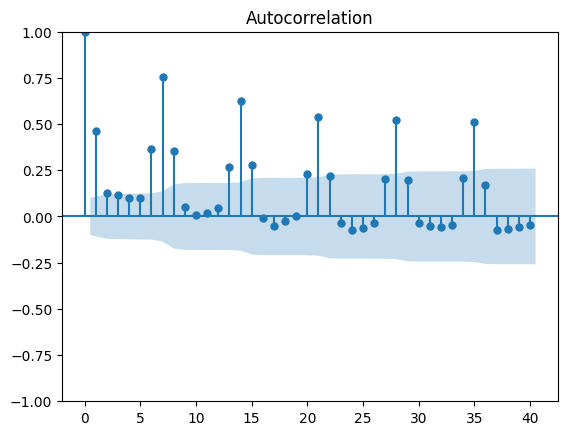

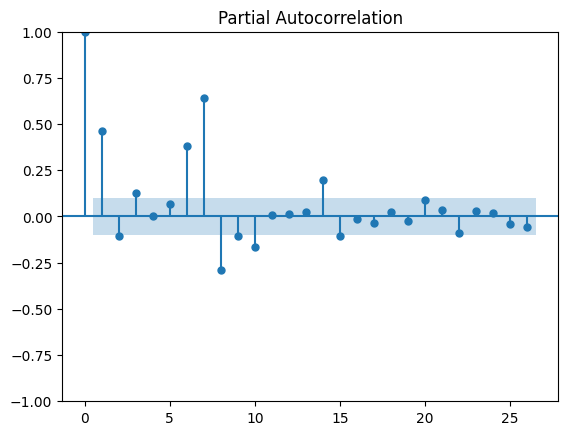

In [19]:
plot_acf(timeseries_count, lags=40)
plot_pacf(timeseries_count)
    
decompose = seasonal_decompose(timeseries_count)
fig = decompose.plot()
fig = mpl_to_plotly(fig)
fig.update_layout(width=1200)
fig.show()

- Количество заказов зависит от даты и времени 
- Существует суточная и недельная сезонность и тренд

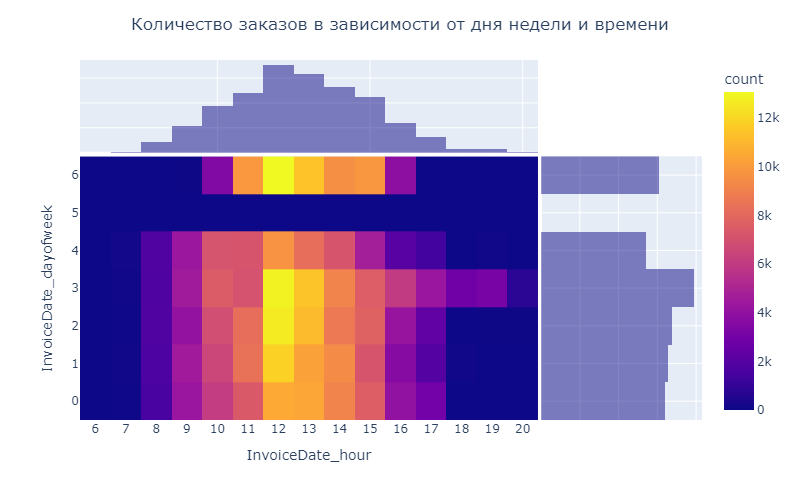

In [20]:
px.density_heatmap(df, y='InvoiceDate_dayofweek', x='InvoiceDate_hour', width=800,  marginal_x="histogram", marginal_y="histogram") \
    .update_layout(title=dict(text='Количество заказов в зависимости от дня недели и времени', x=0.5),
                   xaxis=dict(tickmode='linear'),
                   yaxis=dict(tickmode='linear',
                              tickvals=[0, 1, 2, 3, 4, 5, 6],
                              ticktext=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']))

- Данных за субботу нет
- Наибольшее количество заказов поступает в четверг, наименьшее - в пятницу
- Основная масса заказов поступает в районе 12 часов
- Распределение среднего количества ежедневно поступающих заказов по часу совершения транзакции нормальное

### 2.1. Построение RFM-таблицы и поиск RFM-выбросов

In [21]:
last_day = df['InvoiceDate'].max() + pd.Timedelta(days=1)

recency = (last_day - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
frequency = df[['CustomerID', 'InvoiceNo']].drop_duplicates()['CustomerID'].value_counts()
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

rfm = pd.concat([recency, frequency, monetary], axis=1)
rfm.columns = ['recency', 'frequency', 'monetary']

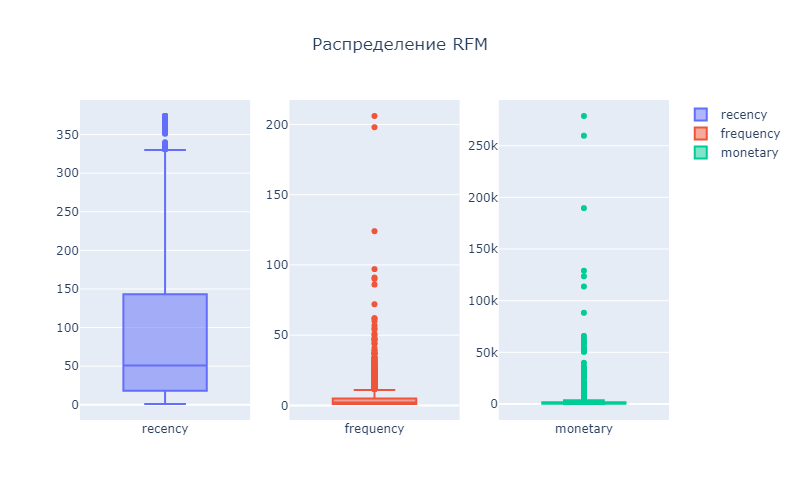

In [22]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Box(y=recency, name='recency'))
fig.add_trace(go.Box(y=frequency, name='frequency'), col=2, row=1)
fig.add_trace(go.Box(y=monetary, name='monetary'), col=3, row=1)
fig.update_layout(width=800, title=dict(text='Распределение RFM', x=0.5)).show()

Признаки frequency и monetary содержат выбросы

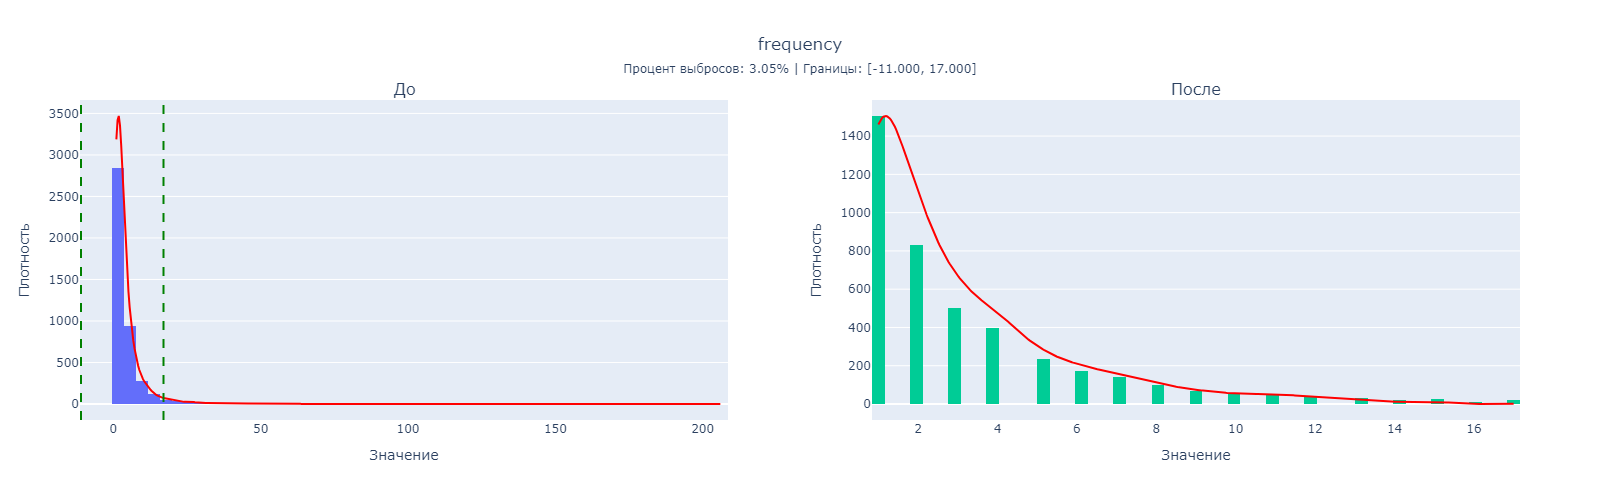

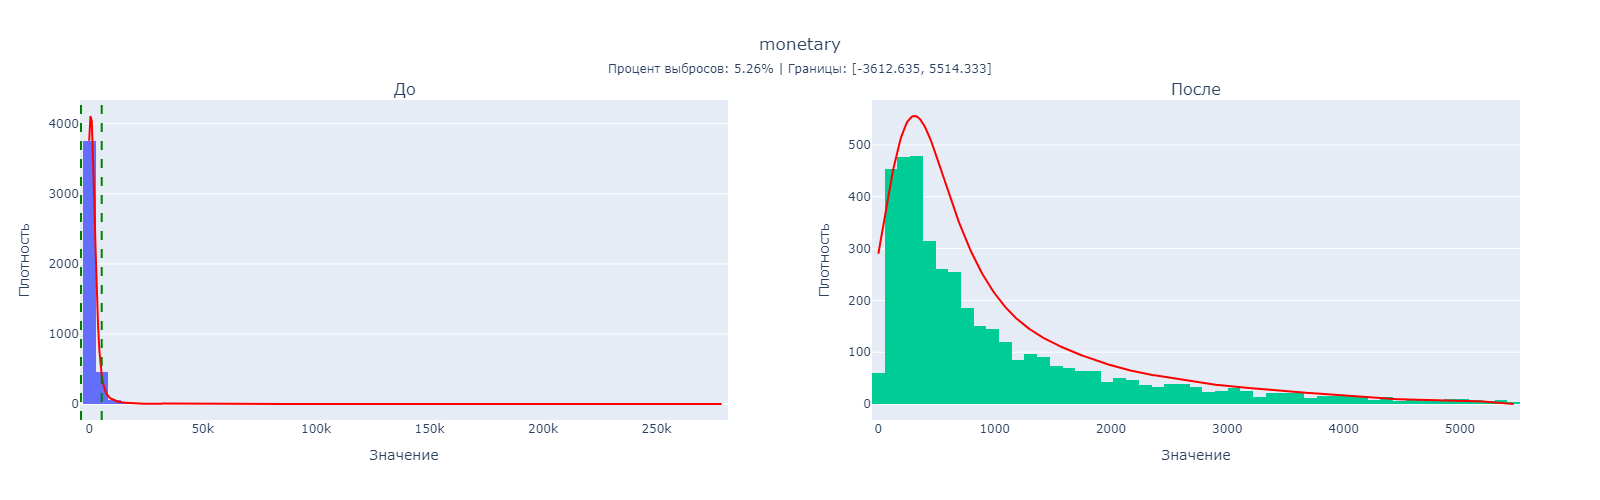

In [23]:
# Удаление выбросов методом межквартильного размаха
rfm = OutlierCleaner(mapping={'frequency': {'right': 3}, 'monetary': {'right': 3}}, method='iqr', verbose=2).fit_transform(rfm)

### 2.2. Выводы

- Практически все клиенты делают заказы из Великобритании
- Больше всех покупают товаров и приносят прибыль клиенты из Ирландии, Нидерландов и Австралии
- Наибольший общий доход приносят клиенты из Великобритании, Нидерландов и Ирландии
- Количество заказов зависит от даты и времени 
- Существует суточная и недельная сезонность и тренд
- Данных за субботу нет
- Наибольшее количество заказов поступает в четверг, наименьшее - в пятницу
- Основная масса заказов поступает в районе 12 часов
- Распределение среднего количества ежедневно поступающих заказов по часу совершения транзакции нормальное

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

In [24]:
rfm[rfm.columns] = PowerTransformer().fit_transform(rfm)

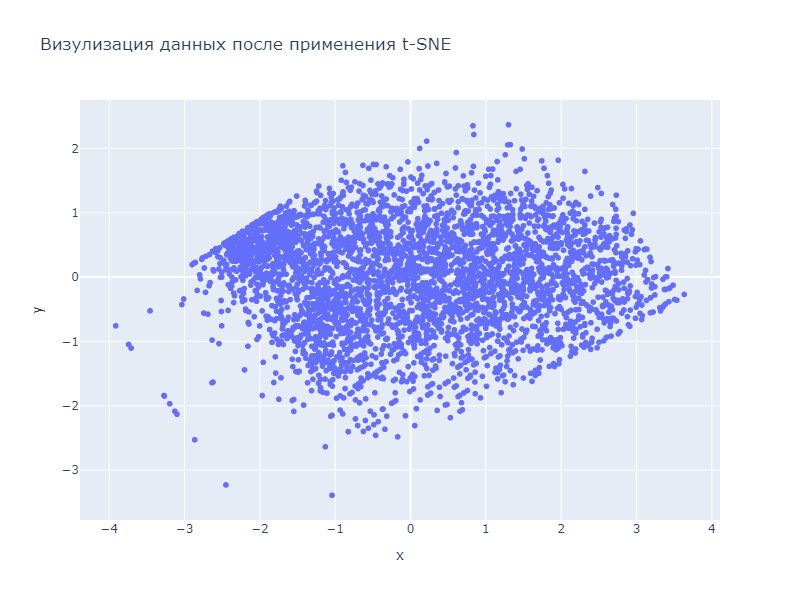

In [ ]:
rfm_pca = pd.DataFrame(PCA(2, random_state=42).fit_transform(rfm), index=rfm.index)
px.scatter(x=rfm_pca[0], y=rfm_pca[1], width=800, height=600, title='Визулизация данных после применения PCA').show()

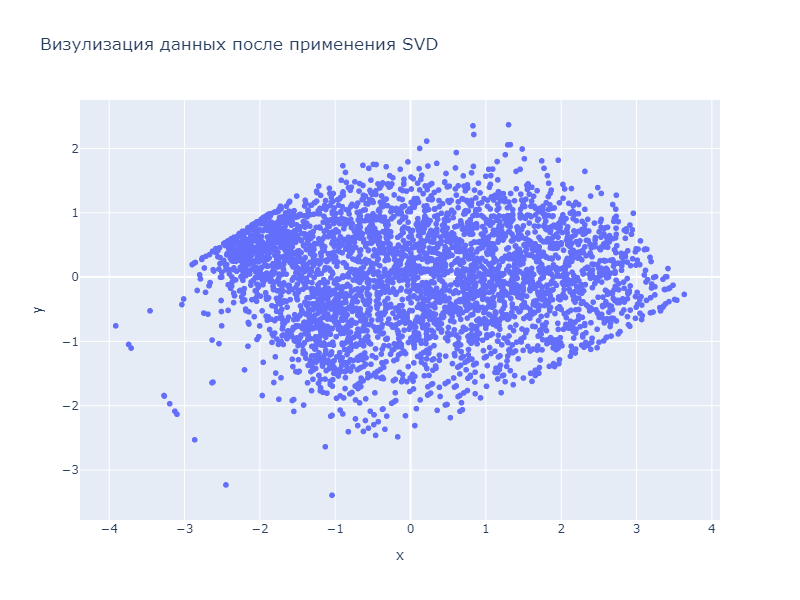

In [ ]:
rfm_svd = pd.DataFrame(TruncatedSVD(2, random_state=42).fit_transform(rfm), index=rfm.index)
px.scatter(x=rfm_svd[0], y=rfm_svd[1], width=800, height=600, title='Визулизация данных после применения SVD').show()

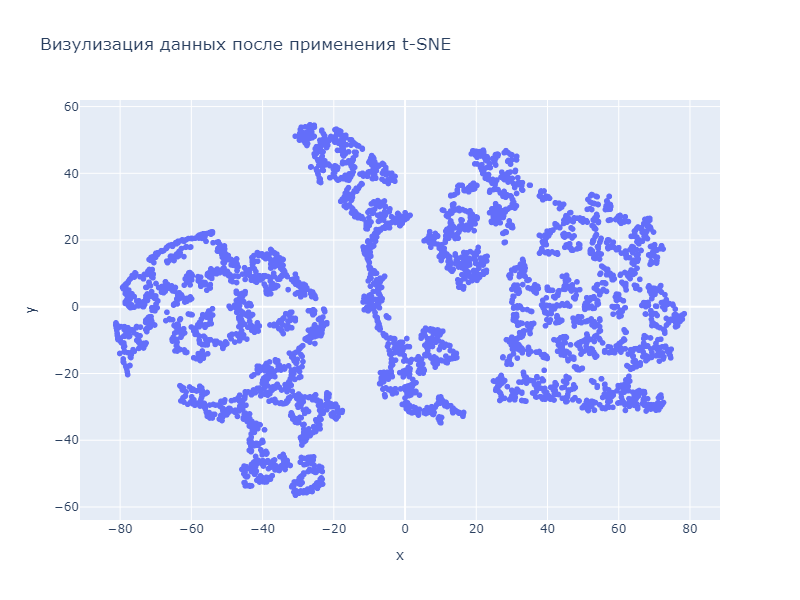

In [ ]:
rfm_tsne = pd.DataFrame(TSNE(2, random_state=42).fit_transform(rfm), index=rfm.index)
px.scatter(x=rfm_tsne[0], y=rfm_tsne[1], width=800, height=600, title='Визулизация данных после применения t-SNE')

Данные после применения t-SNE лучше разделены в пространстве, чем после применения PCA и SVD \
На диаграмме видно, что даные образуют скопления на плоскости. Некоторые скопления имеют вытянутую форму, значит алгоритм KMeans будет давать нелучший результат.

In [ ]:
rfm_reduced = rfm_tsne

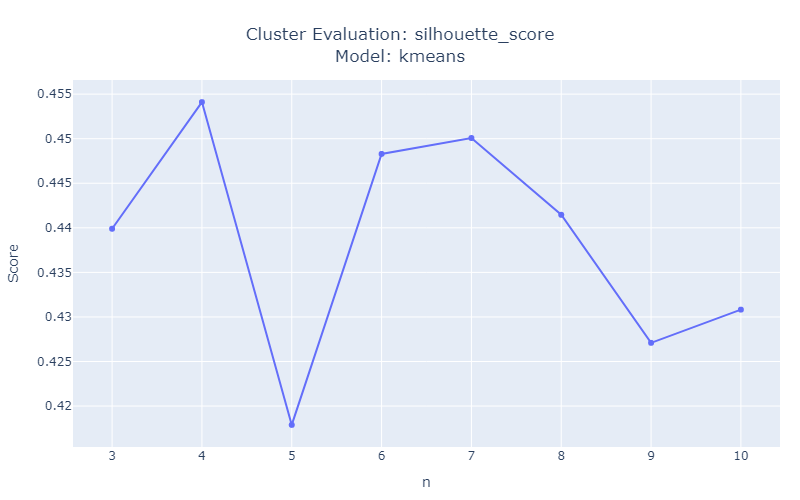

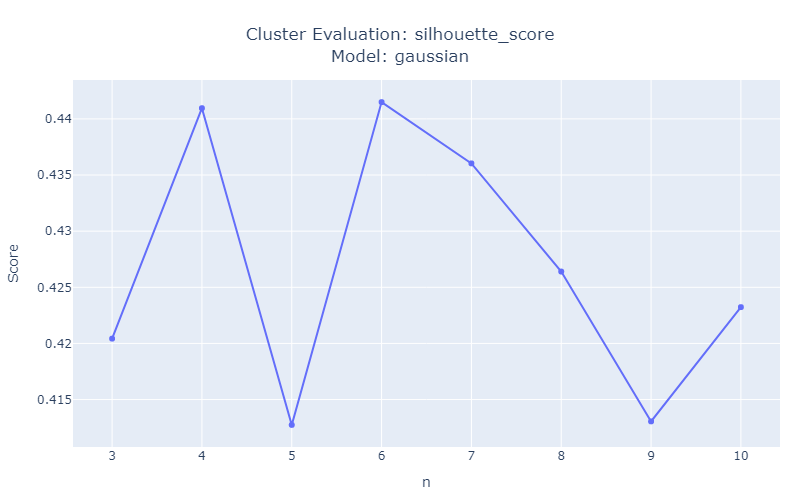

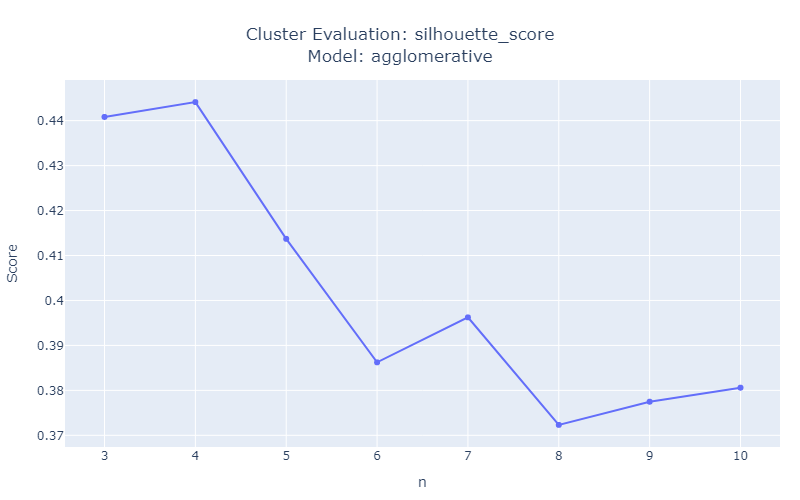

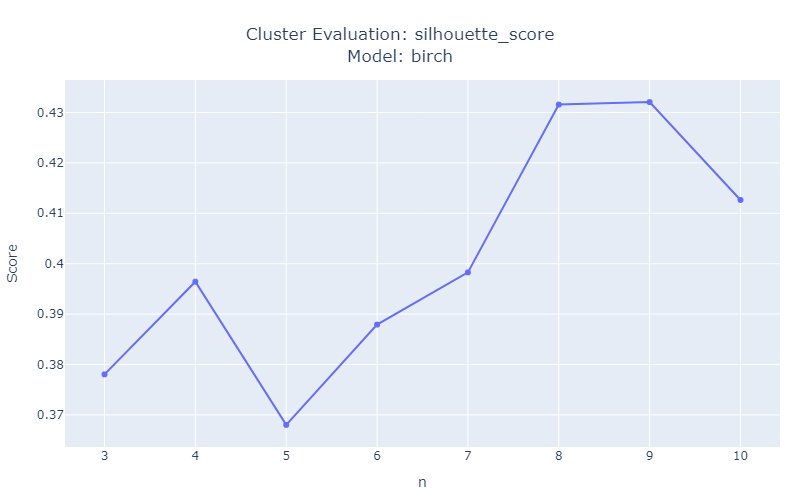

In [26]:

for model in ['kmeans', 'gaussian', 'agglomerative', 'birch']:
    results_df = find_best_n(rfm_reduced, range(3, 11), silhouette_score, model=model, verbose=2)

Исходя из визуализации данных и рассчитанных коэффициентов силуэта для разного количества кластеров, принято решение выбрать модель GaussianMixture с количеством кластеров - 6

In [27]:
y_pred = pd.Series(GaussianMixture(6, random_state=42).fit_predict(rfm_reduced[[0,1]]).astype(str), name='cluster', index=rfm_reduced.index)

### 3.2. Интерпретация результатов кластеризации

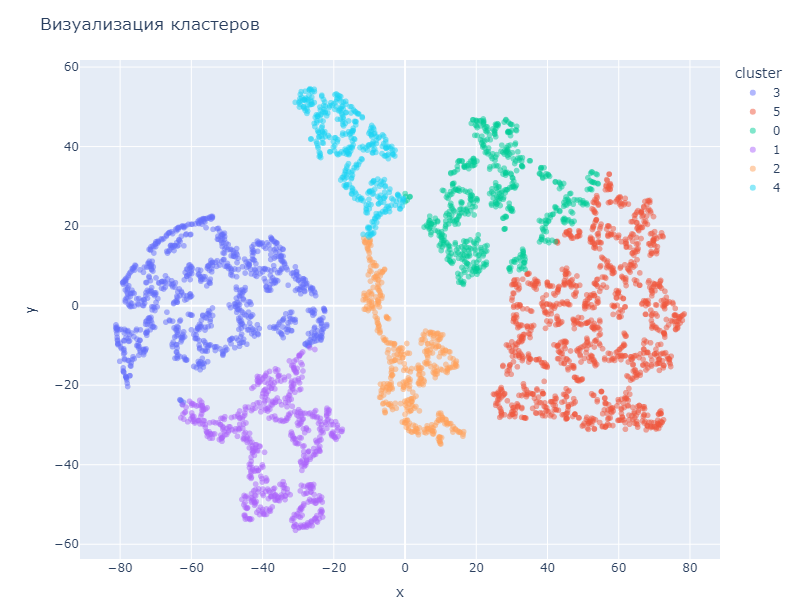

In [28]:
px.scatter(x=rfm_reduced[0], y=rfm_reduced[1], opacity=0.5, color=y_pred, width=800, height=600) \
    .update_layout(coloraxis_colorbar_title='RFM score', title=dict(text='Визуализация кластеров'), margin=dict(b=0),
                   scene_camera_projection_type='orthographic', legend_title='cluster')

В целом данные корректно разделились на 6 кластеров 

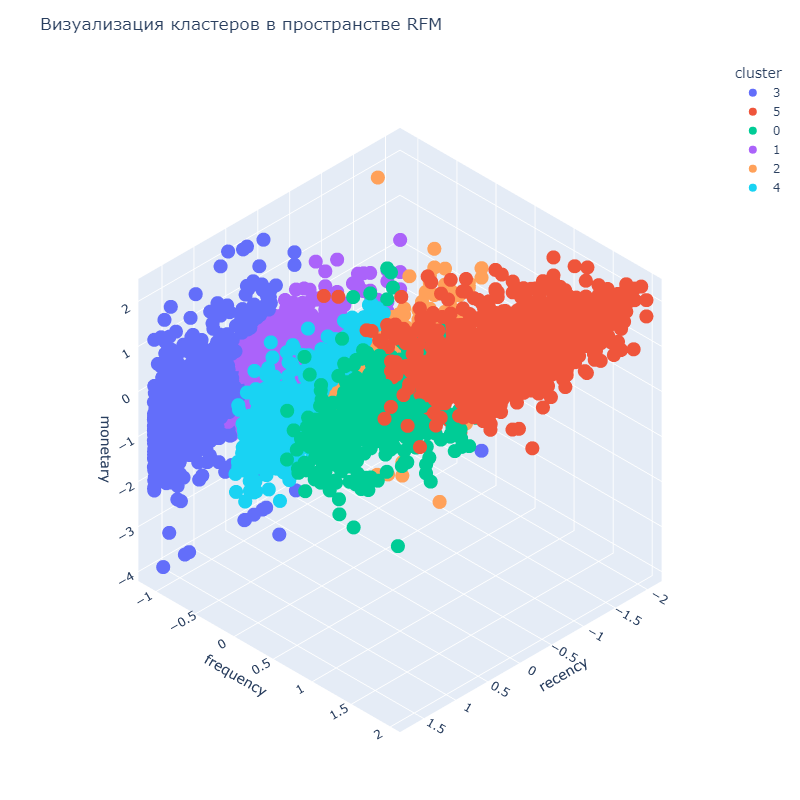

In [68]:
px.scatter_3d(x=rfm['recency'], y=rfm['frequency'], z=rfm['monetary'], color=y_pred, labels={'x': 'recency', 'y': 'frequency', 'z': 'monetary'}, width=800, height=800) \
    .update_layout(coloraxis_colorbar_title='RFM score', title=dict(text='Визуализация кластеров в пространстве RFM'), margin=dict(b=0),
                   scene_aspectmode='cube', scene_camera_projection_type='orthographic', legend_title='cluster')

В RFM пространстве есть незначительная неточности

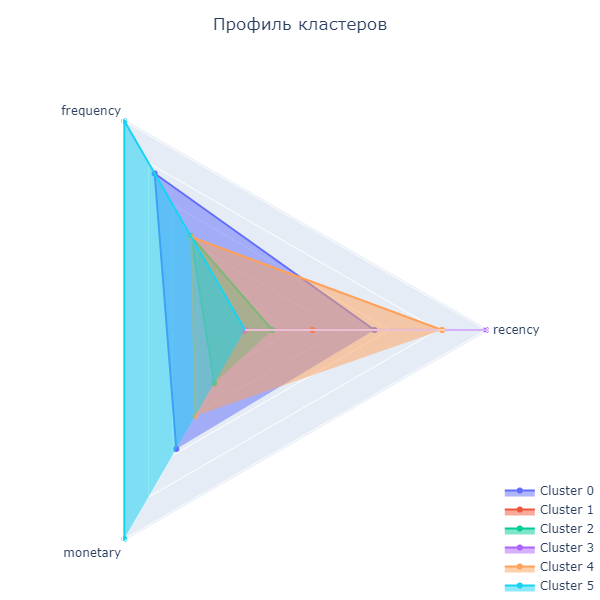

In [71]:
def plot_cluster_profile(grouped_data):
    features = grouped_data.columns
    grouped_data[features] = MinMaxScaler().fit_transform(grouped_data)

    fig = go.Figure()
    for i in grouped_data.index:
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.loc[i].values,
            theta=features,
            fill='toself',
            name=f'Cluster {i}',
        ))
    fig.update_layout(
        width=600, height=600,
        margin=dict(t=60, r=0, l=0, b=0), legend_y=0,
        title_text='Профиль кластеров', title_x=0.5
    ).update_polars(gridshape='linear', radialaxis_showticklabels=False)
    fig.show()


plot_cluster_profile(pd.concat([rfm, y_pred], axis=1).groupby('cluster').mean())

Из профиля кластеров можно выделить 6 групп клиентов:
- Группа 0: клиенты, которые покупают часто, тратят много денег и давно совершили покупку
- Группа 1: клиенты, которые покупают редко, тратят мало денег, и очень давно совершили покупку
- Группа 2: клиенты, которые покупают нечасто, тратят немного денег, и очень давно совершили покупку
- Группа 3: клиенты, которые покупают редко, тратят мало денег, и совсем недавно совершили покупку
- Группа 4: клиенты, которые покупают нечасто, тратят немного денег, и недавно совершили покупку
- Группа 5: клиенты, которые покупают очень часто, тратят очень много денег и очень давно совершили покупку

## 4. Финальные выводы

В ходе работы:
1. Проведена предобработка исходного набора данных о транзакциях;
2. Проведён разведывательный анализ данных, в результате которого были сделаны следующие выводы:
    - Практически все клиенты делают заказы из Великобритании
    - Больше всех покупают товаров и приносят прибыль клиенты из Ирландии, Нидерландов и Австралии
    - Наибольший общий доход приносят клиенты из Великобритании, Нидерландов и Ирландии
    - Количество заказов зависит от даты и времени 
    - Существует суточная и недельная сезонность и тренд
    - Данных за субботу нет
    - Наибольшее количество заказов поступает в четверг, наименьшее - в пятницу
    - Основная масса заказов поступает в районе 12 часов
    - Распределение среднего количества ежедневно поступающих заказов по часу совершения транзакции нормальное
3. Сформирован набор данных о характеристиках (RFM) каждого из уникальных клиентов;
4. Определено оптимальное количество кластеров - 6 и построено несколько моделей машинного обучения (KMeans, GaussianMixture, AgglomerativeClustering и Birch). Среди всех моделей выбрана GaussianMixture.


В итоге выделено 6 групп клиентов:
- Группа 0: клиенты, которые покупают часто, тратят много денег и давно совершили покупку
- Группа 1: клиенты, которые покупают редко, тратят мало денег, и очень давно совершили покупку
- Группа 2: клиенты, которые покупают нечасто, тратят немного денег, и очень давно совершили покупку
- Группа 3: клиенты, которые покупают редко, тратят мало денег, и совсем недавно совершили покупку
- Группа 4: клиенты, которые покупают нечасто, тратят немного денег, и недавно совершили покупку
- Группа 5: клиенты, которые покупают очень часто, тратят очень много денег и очень давно совершили покупку